# Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import random

### Các thư viện I/O, File
import os
import glob
import shutil
import zipfile
### Các thư viện hình ảnh (bổ sung)
from PIL import Image, ImageDraw
import matplotlib.image as mpimg 

###################################################
from sklearn.model_selection import train_test_split
###################################################
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Download data and EDA

In [2]:
#####******FOR COLAB DOWLOAD DATASETS*****#########
GTSRB_DATA_URL = "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip"
tf.keras.utils.get_file(
    fname = 'GTSRB_Final_Training_Images.zip', 
    origin = GTSRB_DATA_URL, 
    cache_subdir='datasets', 
    extract=True
)
DOWNLOAD_PATH = "/root/.keras/datasets/"
GTSRB_DATA_PATH = os.path.join(DOWNLOAD_PATH,  "GTSRB/Final_Training/Images")

276299776/276294756 [==============================] - 10s 0us/step


In [3]:
# DOWNLOAD_PATH = "/Users/macintosh/Desktop"
# GTSRB_DATA_PATH = os.path.join(DOWNLOAD_PATH,  "GTSRB/Final_Training/Images")

In [4]:
N_CLASSES = 43
RESIZED_HIGHT = RESIZED_WIDTH = 32
RESIZED_IMAGE = (RESIZED_HIGHT, RESIZED_WIDTH)

## Load and check all labes

In [5]:
def load_labels_from_one_directory(SOURCE, i):
    dir_name = format(i, '05d')
    dir_path = os.path.join(SOURCE, dir_name)
    filename = 'GT-' + dir_name + '.csv'
    file_path = os.path.join(dir_path, filename)
    df = pd.read_csv(file_path, delimiter=";")
    df['File_path'] = df['Filename'].map(lambda x: os.path.join(dir_path, x))
    df.drop('Filename', axis = 1, inplace = True)
    return df

def load_all_labels(SOURCE):
    list_label_df = []
    for i in range(N_CLASSES):
        df = load_labels_from_one_directory(SOURCE, i)
        list_label_df.append(df)
    return pd.concat(list_label_df, axis = 0, ignore_index=True)

df = load_all_labels(GTSRB_DATA_PATH)

In [6]:
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,File_path
0,29,30,5,6,24,25,0,/root/.keras/datasets/GTSRB/Final_Training/Ima...
1,30,30,5,5,25,25,0,/root/.keras/datasets/GTSRB/Final_Training/Ima...
2,30,30,5,5,25,25,0,/root/.keras/datasets/GTSRB/Final_Training/Ima...
3,31,31,5,5,26,26,0,/root/.keras/datasets/GTSRB/Final_Training/Ima...
4,30,32,5,6,25,26,0,/root/.keras/datasets/GTSRB/Final_Training/Ima...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Width      39209 non-null  int64 
 1   Height     39209 non-null  int64 
 2   Roi.X1     39209 non-null  int64 
 3   Roi.Y1     39209 non-null  int64 
 4   Roi.X2     39209 non-null  int64 
 5   Roi.Y2     39209 non-null  int64 
 6   ClassId    39209 non-null  int64 
 7   File_path  39209 non-null  object
dtypes: int64(7), object(1)
memory usage: 2.4+ MB


In [8]:
df.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000


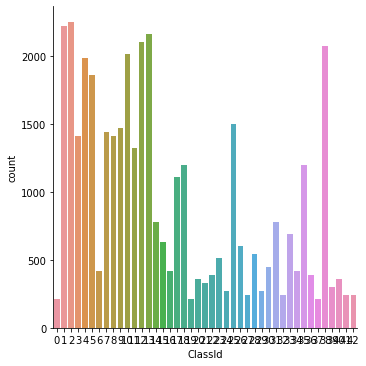

In [9]:
sns.catplot(x = 'ClassId', data = df, kind = 'count');

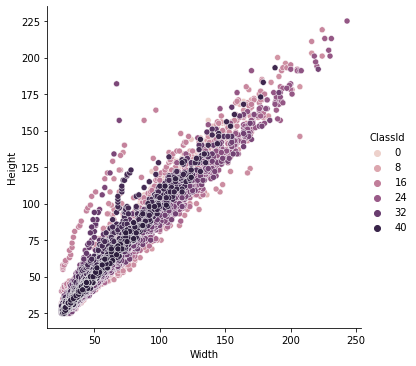

In [10]:
sns.relplot(x = 'Width', y = 'Height', data = df, hue = 'ClassId')

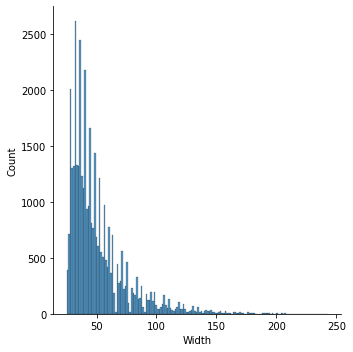

In [11]:
sns.displot( x = "Width", data = df, kind="hist")

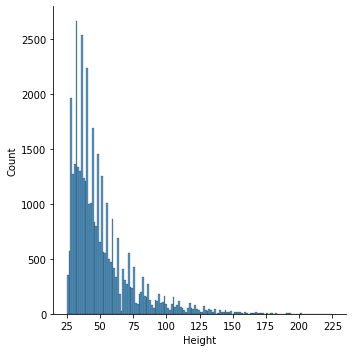

In [12]:
sns.displot( x = "Height", data = df, kind="hist")

In [13]:
# To check the relation between the boxes and the correpoding img size
check_number = min((df['Height'] - df['Roi.Y1']).min(),  
                       (df['Roi.Y2'] - df['Roi.Y1']).min(),
                       (df["Width"] - df['Roi.X1']).min(),
                       (df['Roi.X2'] - df['Roi.X1']).min())
    
if check_number>=0:
    print("All boxes fit  their correpoding img size") 
else:
    print("Have a probem between boxes and img size") 

All boxes fit  their correpoding img size


## View some images with their class and box (randomly)

In [14]:
def show_an_image_with_box(df, j):  
    img_path = df.loc[j]["File_path"]
    with Image.open(img_path) as img:
        box = list(df.loc[j]["Roi.X1":"Roi.Y2"])
        draw = ImageDraw.Draw(img)
        draw.rectangle(box, outline="green", width=1)
        plt.title('class: ' + str(df.loc[j]['ClassId']))
        plt.imshow(img)

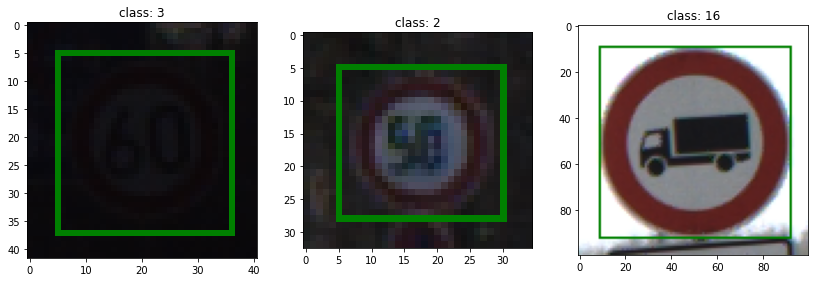

In [15]:
all_img_paths = df["File_path"]
all_idxs = df.index
#choose some random number
nrows = 1 
ncols = 3
rand_Ids=np.random.choice(all_idxs,nrows*ncols)

len(all_idxs)

fig = plt.gcf() 
fig.set_size_inches(14,20)
for i, id_ in enumerate(rand_Ids):
    plt.subplot(nrows, ncols, i+1) 
    show_an_image_with_box(df, id_)

## Load all images in the resized shape

In [16]:
def load_all_images(img_paths = []):
    list_img = []
    for img_path in img_paths:
        #with Image.open(img_path) as img      
        img = tf.keras.preprocessing.image.load_img(img_path, target_size = RESIZED_IMAGE)# Problem: do not close the file
        img = tf.keras.preprocessing.image.img_to_array(img)
        list_img.append(img)
    return  np.array(list_img)
img_paths = list(df["File_path"])
imgs = load_all_images(img_paths)

In [17]:
# def update_box():
#     df['resized_Roi.X1']  =  df['Roi.X1'] * RESIZED_WIDTH / df['Width']
#     df['resized_Roi.X2']  =  df['Roi.X2'] * RESIZED_WIDTH / df['Width']
#     df['resized_Roi.Y1']  =  df['Roi.Y1'] * RESIZED_HIGHT / df['Height']
#     df['resized_Roi.X2']  =  df['Roi.Y2'] * RESIZED_HIGHT / df['Height']
# update_box()

In [18]:
def add_rate_coordinates_box():
    """Using for the target"""
    df['rate_y_min'] = df['Roi.Y1'] /df.Height
    df['rate_x_min'] = df['Roi.X1'] /df.Width
    df['rate_y_max'] = df['Roi.Y2'] /df.Height
    df['rate_x_max'] = df['Roi.X2'] /df.Width
add_rate_coordinates_box()

In [19]:
def plot_image_with_box(img, box):
    """by using tf"""
    colors = np.array([[255,0,0]]) #red colors
    #img_arr = np.asarray(resized_img)
    img_arr = np.expand_dims(img, axis =0)
    
    box = box.reshape([1, 1, 4])
    
    new_img = tf.image.draw_bounding_boxes(img_arr, box, colors)
    plt.imshow(new_img[0]/255.0)
    plt.title('Resized image with box')
    plt.show()

Randonm index =  36523


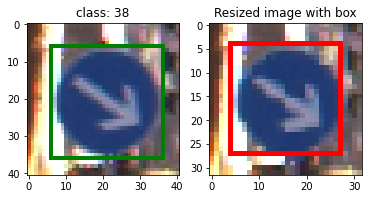

In [20]:
# show image before and after resize
all_idxs = df.index
rand_Id=np.random.choice(all_idxs)
print('Randonm index = ', rand_Id)


fig = plt.figure()
plt.subplot(1, 2, 1) 
show_an_image_with_box(df, rand_Id)
plt.subplot(1, 2, 2)
box = np.array(df.loc[rand_Id]['rate_y_min':'rate_x_max'])
plot_image_with_box(imgs[rand_Id], box)

# Creat train and test sets

## Train/Split data and Transformation function

In [62]:
#Creat split data
from sklearn.model_selection import train_test_split

y = df[["ClassId"]].values
id_train, id_test, y_train, y_test = train_test_split(range(df.shape[0]), y, shuffle = True,
                                                            stratify = y, 
                                                      train_size = 0.8, random_state = 42)
X_train = imgs[id_train]
X_test = imgs[id_test] 

target_boxes_train = df.loc[id_train, 'rate_y_min':'rate_x_max'].values
target_boxes_test = df.loc[id_test,'rate_y_min':'rate_x_max'].values

In [63]:
X_train.shape, X_test.shape, y_train.shape,  y_test.shape

((31367, 32, 32, 3), (7842, 32, 32, 3), (31367, 1), (7842, 1))

In [64]:
target_boxes_train.shape, target_boxes_test.shape

((31367, 4), (7842, 4))

In [65]:
#TRANSFORMATION FUNCTION
def transform(img, b, c, is_training = True):
    #a = tf.cast(a/255, tf.float32)
    #b = tf.cast(b, tf.float32)
    #c = tf.cast(c, tf.float32)
    rand = tf.random.uniform([1])
    if is_training and (rand >0.5):
        img = tf.image.random_brightness(img, max_delta = 0.95)
    return img/255, (b, c)

## Make  a tf.data Data with transformation

In [66]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  #Version 2.0
##AUTOTUNE = tf.data.AUTOTUNE  #Version 2.xx

def creat_dataset(X, y, target_boxes, batch_size, is_training = True):  #batch_size,
    ds = tf.data.Dataset.from_tensor_slices((X, y, target_boxes))  # Tạo một LIST các cặp X_i, y_i
    ds = ds.map(lambda a, b, c: transform(a, b, c, is_training))  #, num_parallel_calls = AUTOTUNE
    #dataset.map(time_consuming_mapping).cache().map(memory_consuming_mapping)
    if is_training:
        m = target_boxes.shape[0]
        shuffle_buffer = m              
        ds = ds.shuffle(shuffle_buffer)
    #ds = ds.repeat() # Mandatory for Keras for now
    ds = ds.batch(batch_size, drop_remainder = True).prefetch(1)   # Thêm chiều cho trục axis = 0 cho list bên trên 
    return ds

In [67]:
BATCH_SIZE = 64
ds_train = creat_dataset(X_train, y_train, target_boxes_train, BATCH_SIZE)
ds_test = creat_dataset(X_test, y_test, target_boxes_test, BATCH_SIZE//2, is_training = False)

In [68]:
ds_train.element_spec

(TensorSpec(shape=(64, 32, 32, 3), dtype=tf.float32, name=None),
 (TensorSpec(shape=(64, 1), dtype=tf.int64, name=None),
  TensorSpec(shape=(64, 4), dtype=tf.float64, name=None)))

In [69]:
ds_train.element_spec

(TensorSpec(shape=(64, 32, 32, 3), dtype=tf.float32, name=None),
 (TensorSpec(shape=(64, 1), dtype=tf.int64, name=None),
  TensorSpec(shape=(64, 4), dtype=tf.float64, name=None)))

In [70]:
# import multiprocessing
# cores = multiprocessing.cpu_count()
# ## num_parallel_calls= cores ##
# print(cores)

# Model

In [71]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, Lambda 
from tensorflow.keras.models import Model
from tensorflow.python.keras.utils.vis_utils import plot_model

## Architectu

### Pipeline layers

In [72]:
@tf.function
def my_pipeline_function(img):
    if tf.math.reduce_mean(img) < 0.3 :
        img = tf.image.adjust_contrast(img, 5)
        img = tf.image.adjust_brightness(img, 0.2)
    return img

def my_pipeline_layers():
    return Lambda(lambda input_layer: my_pipeline_function(input_layer))


### Buid model

In [73]:
def build_model():
    input_layer = Input(shape=(RESIZED_HIGHT, RESIZED_WIDTH, 3))
    x = my_pipeline_layers()(input_layer)
    Conv2D(32, (5,5), activation = 'relu')(x)
    Conv2D(64, (5,5), activation = 'relu')(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)
    clf_output = Dense(N_CLASSES, activation='softmax', name = 'ouput_clf')(x)
    box_output = Dense(4, name = 'ouput_reg')(x)
    model = Model(inputs = input_layer, outputs = [clf_output, box_output])
    return model
model = build_model()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 32, 32, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 3072)         0           lambda_2[0][0]                   
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1024)         3146752     flatten_2[0][0]                  
____________________________________________________________________________________________

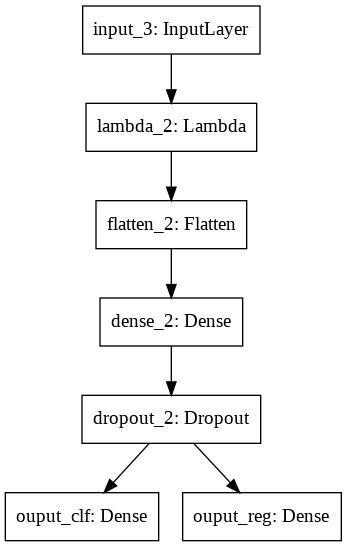

In [74]:
model.summary()
plot_model(model)

## Optimization

In [75]:
def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  tf.split(pred_box, 4, axis = 0)
    xmin_true, ymin_true, xmax_true, ymax_true = tf.split(true_box, 4, axis = 0)


    xmin_overlap = tf.math.maximum(xmin_pred, xmin_true)
    xmax_overlap = tf.math.minimum(xmax_pred, xmax_true)
    ymin_overlap = tf.math.maximum(xmin_pred, xmin_true)
    ymax_overlap = tf.math.minimum(ymax_pred, ymax_true)

    pred_box_area = (xmax_pred - xmin_pred ) * (ymax_pred - ymin_pred )
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    overlap_area = tf.math.maximum((xmax_overlap - xmin_overlap), 0)  * tf.math.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    iou = overlap_area / union_area

    return iou

In [76]:
    #model.compile(loss=["mse", "mse"], , optimizer="sgd")
    model.compile(optimizer='adam',
                  loss=['sparse_categorical_crossentropy', 'mse'],
                  #loss_weights=[0.5, 0.5],
                  metrics= ['accuracy', intersection_over_union])

# Training process

In [78]:
model.fit(ds_train, 
          validation_data=ds_test,
          epochs=100)

Epoch 1/100
490/490 [==============================] - 4s 6ms/step - loss: 0.9759 - ouput_clf_loss: 1.8818 - ouput_reg_loss: 0.0701 - ouput_clf_accuracy: 0.4879 - ouput_clf_intersection_over_union: -4.6096e-05 - ouput_reg_accuracy: 0.5060 - ouput_reg_intersection_over_union: -2.9299e-04 - val_loss: 0.6785 - val_ouput_clf_loss: 1.3097 - val_ouput_reg_loss: 0.0472 - val_ouput_clf_accuracy: 0.7084 - val_ouput_clf_intersection_over_union: nan - val_ouput_reg_accuracy: 0.4048 - val_ouput_reg_intersection_over_union: -3.2700e-04
Epoch 2/100
490/490 [==============================] - 4s 6ms/step - loss: 0.7604 - ouput_clf_loss: 1.4786 - ouput_reg_loss: 0.0422 - ouput_clf_accuracy: 0.5913 - ouput_clf_intersection_over_union: nan - ouput_reg_accuracy: 0.4608 - ouput_reg_intersection_over_union: -0.0231 - val_loss: 0.5223 - val_ouput_clf_loss: 1.0242 - val_ouput_reg_loss: 0.0203 - val_ouput_clf_accuracy: 0.7388 - val_ouput_clf_intersection_over_union: nan - val_ouput_reg_accuracy: 0.4202 - val_o

KeyboardInterrupt: ignored

In [ ]:
# EPOCHS = 20 # 45
# steps_per_epoch = len(y_train)//64  
# validation_steps = len(y_test)//16

# #model.fit()
# history = model.fit(train_ds, epochs=EPOCHS,
#                     steps_per_epoch=steps_per_epoch
#                     #validation_data=test_ds, 
#                     #validation_steps=validation_steps
                    )